In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.transform import rotation
from sklearn.model_selection import train_test_split 
import heejin
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler,RobustScaler

### 데이터 확인 및 전처리

In [2]:
mpgDF = pd.read_csv('../data/auto-mpg.csv')
mpgDF.info() # horsepower 타입 이상 -> 확인   # model_year - datetime아님

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [23]:
mpgDF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# 필요없는 컬럼 제거
mpgDF.drop(labels='car name', axis = 1, inplace=True)

In [4]:
# horsepower 결측치 제거 or 대체
mpgDF['horsepower'].replace('?',np.nan, inplace=True)
drop_horsepower = mpgDF['horsepower'].dropna()
mpgDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


In [7]:
mpgDF['horsepower'] = mpgDF['horsepower'].astype('float')
heejin.fill_outliers_z(mpgDF['horsepower'],1,'mean')

0      104.848214
1      165.000000
2      150.000000
3      150.000000
4      104.848214
          ...    
393    104.848214
394     52.000000
395    104.848214
396    104.848214
397    104.848214
Name: horsepower, Length: 398, dtype: float64

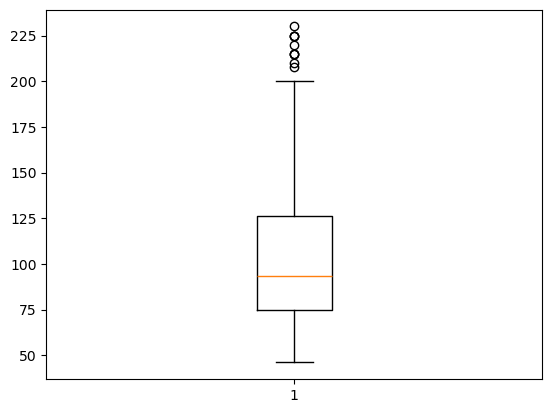

In [26]:
# horsepower boxplot
drop_horsepower = drop_horsepower.astype('float')
plt.boxplot(drop_horsepower)
plt.show()

# 이상치 많이 존재 -> 중앙값으로 대체
mpgDF['horsepower'] = mpgDF['horsepower'].astype('float')
mpgDF['horsepower'].fillna(mpgDF['horsepower'].median(),inplace=True)

In [27]:
# 상관계수 확인
mpgDF.corr(numeric_only=True)['mpg'].abs().sort_values(ascending=False) 

mpg             1.000000
weight          0.831741
displacement    0.804203
cylinders       0.775396
horsepower      0.773453
model year      0.579267
origin          0.563450
acceleration    0.420289
Name: mpg, dtype: float64

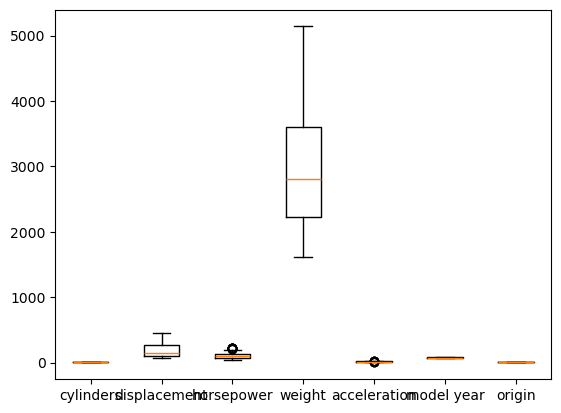

In [28]:
plt.boxplot(mpgDF[mpgDF.columns[1:]])
plt.xticks([1,2,3,4,5,6,7],mpgDF.columns[1:])
plt.show()
# 이상치 처리하고 스케일링 하는 것이 좋겠다.

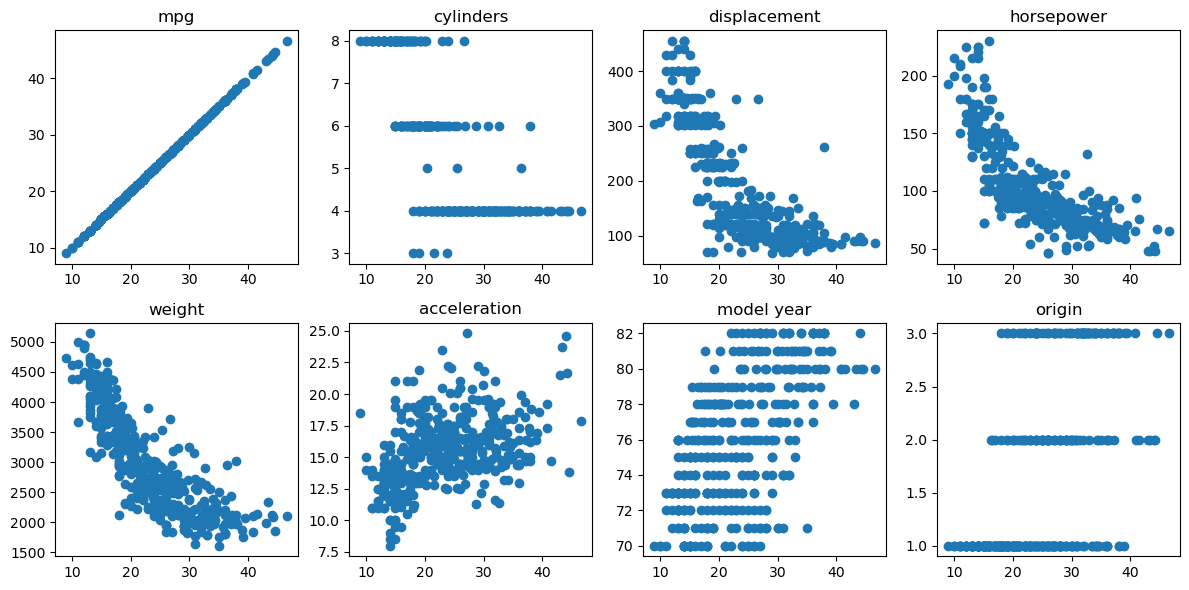

In [29]:
n = 1
plt.figure(figsize=(12,6))
for i in mpgDF.columns:
    plt.subplot(2,4,n)
    plt.scatter(mpgDF['mpg'],mpgDF[i])
    plt.title(f'{i}')
    n+=1
plt.tight_layout()

In [30]:
targetSR = mpgDF['mpg']
featureDF = mpgDF[['weight','displacement','horsepower','cylinders','model year','origin']]
featureDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weight        398 non-null    int64  
 1   displacement  398 non-null    float64
 2   horsepower    398 non-null    float64
 3   cylinders     398 non-null    int64  
 4   model year    398 non-null    int64  
 5   origin        398 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 18.8 KB


(array([13., 78., 73., 61., 54., 48., 38., 22.,  5.,  6.]),
 array([ 9.  , 12.76, 16.52, 20.28, 24.04, 27.8 , 31.56, 35.32, 39.08,
        42.84, 46.6 ]),
 <BarContainer object of 10 artists>)

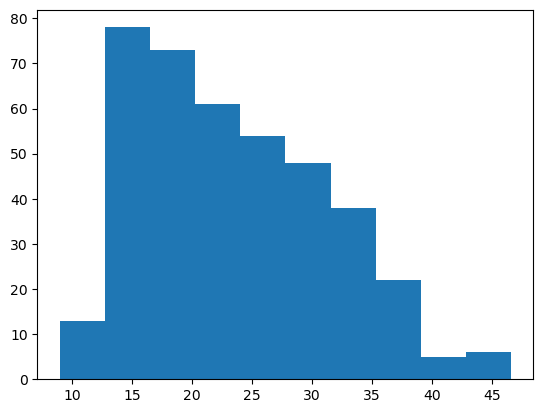

In [31]:
plt.hist(targetSR)

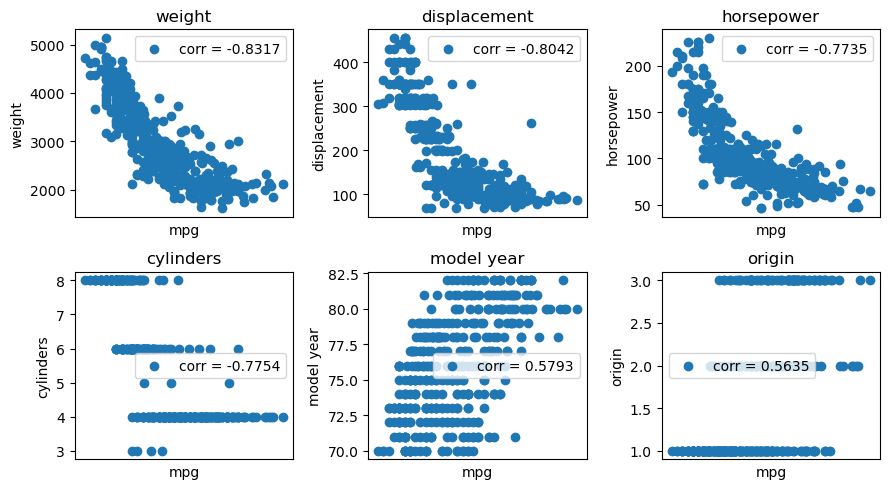

In [32]:
plt.figure(figsize=(9,5))
heejin.print_scatter(2, 3, targetSR, featureDF)

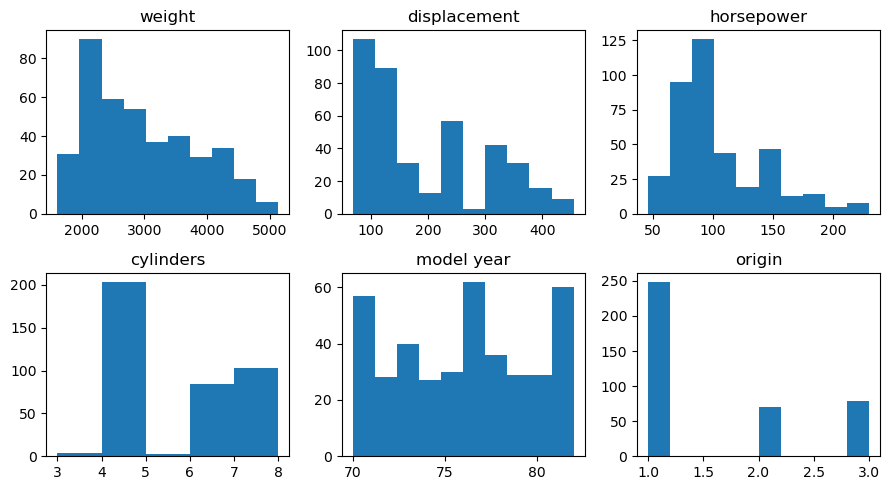

In [33]:
n = 1
plt.figure(figsize=(9,5))
for i in featureDF.columns:
    plt.subplot(2,3,n)
    if i == 'cylinders':
        plt.hist(featureDF[i],bins=5)
        plt.xticks(range(3,9))
    else:
        plt.hist(featureDF[i])
    plt.title(f'{i}')
    n += 1
plt.tight_layout()

### 모델 학습 준비 및 학습

In [34]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor

In [35]:
# 최적 random_state 값 찾기

random_state_list = []
for i in range(1,51):
    xtrain,xtest,ytrain,ytest = train_test_split(featureDF,targetSR,test_size=0.2,random_state=i)
    scaler = StandardScaler() # scaler 종류에 따른 큰 차이 없음
    scaler.fit(xtrain)
    xtrain_scaled = scaler.transform(xtrain)
    xtest_scaled = scaler.transform(xtest)
    model = KNeighborsRegressor() # model 종류에 따라 차이남
    model.fit(xtrain_scaled,ytrain)
    model.score(xtest_scaled,ytest)
    random_state_list.append(model.score(xtest_scaled,ytest))
max_score = max(random_state_list)
print(f'radom_state = {random_state_list.index(max_score)+1}\nscore : {max_score}')

max_random_state = random_state_list.index(max_score)+1

# 최적 random_state 값
# LinearRegression() : 31
# KNeighborsRegressor() : 27

radom_state = 27
score : 0.9308248730520967


In [36]:
xtrain,xtest,ytrain,ytest = train_test_split(featureDF,targetSR,test_size=0.2,random_state=19)

In [37]:
# poly 최적의 파라미터 값 찾기

max_score = []
for b in [True,False]:
    for d in range(1,6):
        poly = PolynomialFeatures(interaction_only=b, degree=d)
        poly.fit(xtrain)
        xtrain_transformed = poly.transform(xtrain)
        xtest_transformed = poly.transform(xtest)
        
        model = LinearRegression()
        model.fit(xtrain_transformed, ytrain)
        score = model.score(xtest_transformed, ytest)
        print(b,d,score)
        max_score.append([b,d,score])
        
max_element = max(max_score, key=lambda x: x[2])

b_max, d_max, score_max = max_element[0], max_element[1], max_element[2]

print(f'max score =>\ninteraction_only = {b_max}, degree = {d_max}, score = {score_max}')

True 1 0.8498046268901818
True 2 0.8910815207180633
True 3 0.8362647470262158
True 4 0.36038016165734366
True 5 -1.5954695946771964
False 1 0.8498046268901818
False 2 0.8658433299515828
False 3 0.5011546749871214
False 4 -254.94218663648954
False 5 -512.9270590662661
max score =>
interaction_only = True, degree = 2, score = 0.8910815207180633


In [38]:
poly = PolynomialFeatures(interaction_only=b_max,degree=d_max)
xtrain_poly = poly.fit_transform(xtrain)
xtest_poly = poly.transform(xtest)

### 스케일러 별, 모델 별 모델 비교 및 최적의 모델 선택

In [39]:
# 피쳐 조합한 data
model_poly,scaler_poly,score_poly = heejin.find_re_model(xtrain_poly,ytrain,xtest_poly,ytest,'r2')

----------------탐색중------------------
model : KNeighborsRegressor(n_neighbors=4)
scaler : StandardScaler()
Train score : 0.9185704960021548
Test score : 0.9118017849946923

    [모델 설명도]
R2 : 0.9118017849946923
[에러]
MAE : 1.6168749999999998
MSE : 4.376015624999999
RMSE : 2.0918928330581372
--------------------------------------
    
model : LinearRegression()
scaler : StandardScaler()
Train score : 0.8745274138060052
Test score : 0.8910815207183161

    [모델 설명도]
R2 : 0.8910815207183161
[에러]
MAE : 1.815948415854034
MSE : 5.404065911755747
RMSE : 2.3246646880261563
--------------------------------------
    
----------------탐색중------------------
model : KNeighborsRegressor(n_neighbors=4)
scaler : MinMaxScaler()
Train score : 0.9194755602719432
Test score : 0.916301999203629

    [모델 설명도]
R2 : 0.916301999203629
[에러]
MAE : 1.6068749999999998
MSE : 4.152734375
RMSE : 2.0378258941823266
--------------------------------------
    
model : LinearRegression()
scaler : MinMaxScaler()
Train score 

KeyboardInterrupt: 

In [ ]:
# 피쳐 조합 안한 data
model,scaler,score = heejin.find_re_model(xtrain,ytrain,xtest,ytest,'rmse')

'weight','displacement','horsepower','cylinders' => score : 0.864  
'weight','displacement','horsepower' => score : 0.84  
'weight','displacement','horsepower','cylinders','acceleration' => score : 0.868  
'weight','displacement','horsepower','cylinders','model year' => score : 0.90  
'weight','displacement','horsepower','cylinders','origin' => score : 0.853  
<b>'weight','displacement','horsepower','cylinders','model year','origin' => score : 0.92</b>  
'weight','displacement','horsepower','cylinders','model year','origin','acceleration' => score : 0.90  

### 최적의 모델
== poly ==  
data : 'weight','displacement','horsepower','cylinders','model year','origin’  
scaler : RobustScaler()  
    random_state = 27  
model : KNeighborsRegressor(n_neighbors=4)  
Train score : 0.9099697044138406  
Test score : 0.919920750881368  
R2 : 0.919920750881368  
[에러]  
MAE : 1.578125  
MSE : 3.9731875000000003  
RMSE : 1.9932856042223352  
  
or
  
data : 'weight','displacement','horsepower','cylinders','model year','origin’  
scaler : MinMaxScaler()  
    random_state = 27  
model : KNeighborsRegressor(n_neighbors=4)  
Train score : 0.9195591085029653  
Test score : 0.9146378017237742  
R2 : 0.9146378017237742  
[에러]  
MAE : 1.6184374999999995  
MSE : 4.2353046875  
RMSE : 2.057985589721172  
  
or  
  
== poly ==  
data : 'weight','displacement','horsepower','cylinders','model year','origin’  
scaler :  MinMaxScaler()  
    random_state = 31  
model : LinearRegression()  
Train score : 0.8726864281058413  
Test score : 0.9292919580187903  
R2 : 0.9292919580187903  
[에러]  
MAE : 1.6736670896841404  
MSE : 4.863067558630119  
RMSE : 2.2052363951808247  